In [1]:
import numpy as np
import keras
import os, shutil
keras.__version__

Using TensorFlow backend.


'2.2.5'

## Feature extraction (metodo 1)

* Ejecutar base convolucional sobre el dataset.
* guardar su salida en una matriz Numpy en el disco.
* Usar la información como entrada para un clasificador densamente conectado e independiente.

## Instanciar modelo VGG16

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Procesar datos
* Ejecutar base convolucional sobre dataset.

In [39]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './process'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

batch_size = 20

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

def extract_features(directory, sample_count):
  
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 120))
    
    generator = datagen.flow_from_directory(
            directory,
            target_size=(150, 150),
            batch_size=20,
            class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        if i * batch_size >= sample_count:
            # Notar que este generador devuelve data indefinidamente en un loop,
            # debemos cortarlo con un "break" despues de que cada imagen haya sido vista una vez
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


## Aplanar los datos de `(samples, 4, 4, 512)` a la forma `(samples, 8192)`

In [40]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## Modelo clasificador

In [41]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(120, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(
        train_features, 
        train_labels,
        epochs=150,
        batch_size=20,
        validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/150
2000/2000 [==============================] - 12s 6ms/step - loss: 5.1100 - acc: 0.0070 - val_loss: 4.7991 - val_acc: 0.0130
Epoch 2/150
2000/2000 [==============================] - 11s 6ms/step - loss: 4.8822 - acc: 0.0110 - val_loss: 4.7887 - val_acc: 0.0060
Epoch 3/150
2000/2000 [==============================] - 11s 6ms/step - loss: 4.8341 - acc: 0.0100 - val_loss: 4.7859 - val_acc: 0.0100
Epoch 4/150
2000/2000 [==============================] - 11s 6ms/step - loss: 4.8076 - acc: 0.0085 - val_loss: 4.7822 - val_acc: 0.0150
Epoch 5/150
2000/2000 [==============================] - 11s 6ms/step - loss: 4.7851 - acc: 0.0130 - val_loss: 4.7828 - val_acc: 0.0120
Epoch 6/150
2000/2000 [==============================] - 11s 6ms/step - loss: 4.7618 - acc: 0.0140 - val_loss: 4.7810 - val_acc: 0.0150
Epoch 7/150
2000/2000 [==============================] - 11s 6ms/step - loss: 4.7432 - acc: 0.0190 - val_loss: 4.7803 - val_acc: 0.0120


2000/2000 [==============================] - 11s 6ms/step - loss: 3.0379 - acc: 0.3490 - val_loss: 4.5579 - val_acc: 0.0460
Epoch 61/150
2000/2000 [==============================] - 11s 6ms/step - loss: 3.0354 - acc: 0.3335 - val_loss: 4.5499 - val_acc: 0.0520
Epoch 62/150
2000/2000 [==============================] - 12s 6ms/step - loss: 3.0063 - acc: 0.3490 - val_loss: 4.5530 - val_acc: 0.0500
Epoch 63/150
2000/2000 [==============================] - 11s 6ms/step - loss: 2.9642 - acc: 0.3530 - val_loss: 4.5460 - val_acc: 0.0520
Epoch 64/150
2000/2000 [==============================] - 11s 6ms/step - loss: 2.9275 - acc: 0.3660 - val_loss: 4.5424 - val_acc: 0.0540
Epoch 65/150
2000/2000 [==============================] - 11s 6ms/step - loss: 2.9019 - acc: 0.3755 - val_loss: 4.5372 - val_acc: 0.0520
Epoch 66/150
2000/2000 [==============================] - 11s 6ms/step - loss: 2.8520 - acc: 0.3905 - val_loss: 4.5429 - val_acc: 0.0520
Epoch 67/150
2000/2000 [==============================

Epoch 120/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.3784 - acc: 0.7265 - val_loss: 4.4663 - val_acc: 0.0610
Epoch 121/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.3593 - acc: 0.7340 - val_loss: 4.4666 - val_acc: 0.0590
Epoch 122/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.3367 - acc: 0.7530 - val_loss: 4.4691 - val_acc: 0.0610
Epoch 123/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.3063 - acc: 0.7525 - val_loss: 4.4643 - val_acc: 0.0550
Epoch 124/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2584 - acc: 0.7640 - val_loss: 4.4671 - val_acc: 0.0540
Epoch 125/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2503 - acc: 0.7640 - val_loss: 4.4679 - val_acc: 0.0590
Epoch 126/150
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2310 - acc: 0.7750 - val_loss: 4.4701 - val_acc: 0.0620
Epoch 127/150
2000/2000 [=========

## Graficos

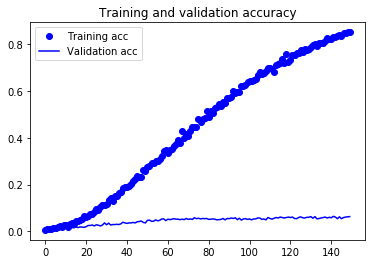

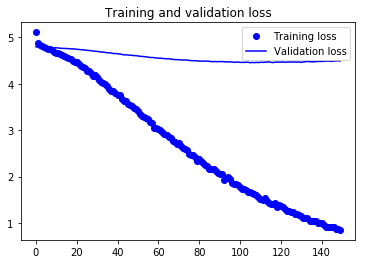

In [42]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Feature extraction (metodo 2)
* Extender el modelo agregando capas densas en la parte superior
* Entrenar toda la red.

## Modelo

In [43]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_17 (Dense)             (None, 120)               30840     
Total params: 16,842,936
Trainable params: 2,128,248
Non-trainable params: 14,714,688
_________________________________________________________________


## Definir como no entrenable la base convolucional

In [44]:
conv_base.trainable = False

## Generadores

In [46]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


## Compila modelo

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

## Entrenamiento

In [50]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30


KeyboardInterrupt: 

## Graficos

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

* Agregar la red personalizada sobre una red base ya entrenada.
* Congelar la red base.
* Entrenar la parte que nueva.
* Descongelar algunas capas en la red base.
* Entrenar conjuntamente estas capas y la parte que nueva.

Hemos completado los primeros 3 pasos cuando realizamos feature extraction.
Avancemos con el 4º paso: descongelaremos nuestra conv_base y luego congelaremos capas individuales dentro de ella.

## Configurar capas

* Se marca como entrenables de la capa `block5_conv1`en adelante.

In [51]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [52]:
# Después de modificar el atributo trainable
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


## Compilar modelo

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

## Entrenamiento

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30


## Graficos

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()